# Speech Recognition with Delta-Delta's
This model will convert recorded speech data into Mel-Spectrogram and then to Delta and finally the Delta-Delta's.

In [112]:
import pandas as pd 
import numpy as np
import math
import os
from scipy import signal 
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
import librosa.display 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.random import set_seed
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Organizing Data
loading in a CSV that was created in EDA https://github.com/Jyve00/Emotion_Dectection/blob/main/EDA.ipynb

In [113]:
Ravdess = '/Users/stephen/Emotion_Detection-/data/RAVDESS/'

ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list.sort

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
1,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
2,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
3,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
4,disgust,/Users/stephen/Emotion_Detection-/data/RAVDESS...


# Data Augmentation Functions
It is common practice to transform audio data with data augmentation tools like time adding white noise, time-stretching and pitch shifts. We'll make duplicates of each wav file so our model will have more variable input data.

.wav file shape: (61929,)
sample rate: 16000


Text(0.5, 1.0, 'Strong Anger')

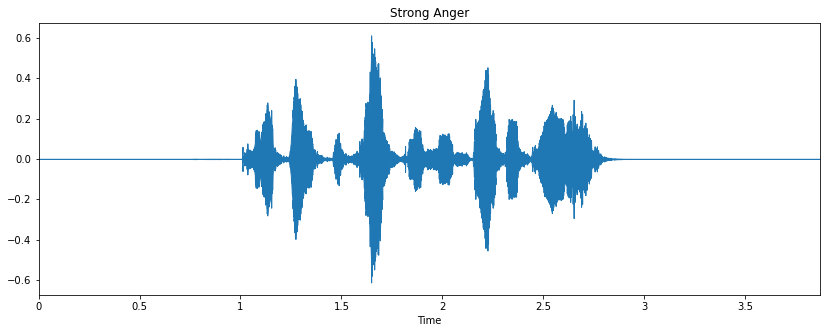

In [114]:
# test ideas and visualize 

# randomly choosen file                                                                     
# Emotion is 'Anger' and Intensity is strong 
test_wav_path = '/Users/stephen/Emotion_Detection-/data/RAVDESS/Actor_04/03-01-05-02-01-02-04.wav'
sig, sr = librosa.load(test_wav_path, sr=16000) # 
print('.wav file shape: ' + str(sig.shape))
print('sample rate: ' + str(sr))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(sig, sr=sr)
plt.title('Strong Anger')

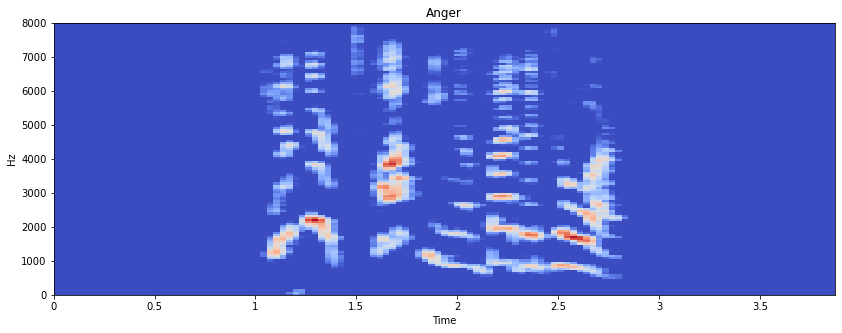

In [115]:
# mellllllsss
mel = librosa.feature.melspectrogram(sig)
mel_db = librosa.amplitude_to_db(mel)
plt.figure(figsize=(14, 5))
plt.title('Anger')
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='hz')

# Feature Extraction
one of the best ASR (automatic Speech Recognition) audio feature extract methods is using a combination of MFCC's, the delta of those MFCC's, and the delta of those deltas (AKA Delta-Deltas). Here we will create functions to

deltas - trajectories of the MFCC coefficients over time

http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

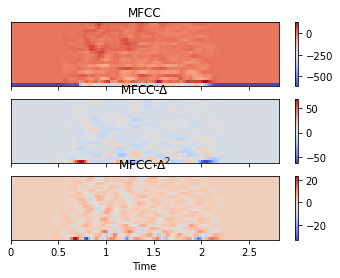

In [116]:
# Showing actual feature extractions used 
# resource: https://librosa.org/doc/main/generated/librosa.feature.delta.html?highlight=delta#librosa.feature.delta

test_mfcc = librosa.feature.mfcc(y=sig, sr=sr)
test_mfcc_delta = librosa.feature.delta(test_mfcc)
test_mfcc_delta2 = librosa.feature.delta(test_mfcc, order=2)




fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img1 = librosa.display.specshow(test_mfcc, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(test_mfcc_delta, ax=ax[1], x_axis='time')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
img3 = librosa.display.specshow(test_mfcc_delta2, ax=ax[2], x_axis='time')
ax[2].set(title=r'MFCC-$\Delta^2$')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])
fig.colorbar(img3, ax=[ax[2]])

# Data Augmentation Functions
It is common practice to transform audio data with data augmentation tools like time adding white noise, time-stretching and pitch shifts. We'll make duplicates of each wav file so our model will have more variable input data.

In [117]:

def noise(data, SNR=10): 
    """
    Adds Additive White Gausian Noise to signal 
    https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb

    the higher the SNR the lower the noise amplitude is 

    Args:
        data (np.darray): audio time series 
        SNR (int, optional): signal to noise ratio. Defaults to 10.

    Returns:
        (np.darray) : [Return original signal plus random noise]
    """
    # RMS value of signal 
    RMS_s = math.sqrt(np.mean(data**2))
    # RMS values of noise 
    RMS_n = math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    # using population formula for standard deviation 
    STD_n = RMS_n 
    noise = np.random.normal(0, STD_n, data.shape[0])
    new_data = data + noise
    return new_data

# Time Strectching 
def stretch(data, rate=0.90):
    """
    

    Args:
        data ([type]): [description]
        rate (float, optional): [description]. Defaults to 0.90.

    Returns:
        [type]: [description]
    """
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-2, high = 3)*1000)
    return np.roll(data, shift_range)

# Pre Emphasis     info on Pre-Emphasis in speech recognition: https://wiki.aalto.fi/display/ITSP/Pre-emphasis
def pre_emphasize(data):
    return librosa.effects.preemphasis(data, coef=1)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sampling_rate, n_steps=1, bins_per_octave=24)


In [118]:
# https://librosa.org/doc/main/generated/librosa.feature.delta.html

def extract_features(data):
    sample_rate = 16000
    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # MFCC Delta
    mfcc_delta = np.mean(librosa.feature.delta(data=mfcc).T, axis=0)
    result = np.hstack((result, mfcc_delta)) # stacking horizontally

    # MFCC Delta-Delta
    mfcc_delta2 = np.mean(librosa.feature.delta(data=mfcc, order=2).T, axis=0)
    result = np.hstack((result, mfcc_delta2)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # Zero-crossing 
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    return result

def get_features(path): 
    # duration and offset are used to take care of the no audio in start and the ending of each audio files .
    _data, sample_rate = librosa.load(path, sr=16000, duration=2.5, offset=0.6) 
    # apply High Pass filter to attenuate all signals below 80 hz
    sos = signal.butter(4, 80, 'hp', fs=1000, output='sos') # butterworth filter 
    data = signal.sosfilt(sos, _data)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    pre_emp_data = pre_emphasize(data)
    res4 = extract_features(pre_emp_data)
    result = np.vstack((result, res4)) # stacking vertically
    
    return result

# Calling Functions and preparing data for CNN
So the outline of our features are:

In [119]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have made 4 augmentation techniques on each audio file.
        Y.append(emotion)

In [120]:
len(X), len(Y), Ravdess_df.Path.shape

(5760, 5760, (1440,))

In [121]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,labels
0,-536.970032,-70.208008,-79.724160,-27.816592,-21.776632,-1.671302,-14.497605,-9.052683,4.116251,5.237724,...,0.011748,0.011426,0.010883,0.006832,0.004739,0.003541,0.000767,0.000079,0.365080,angry
1,-292.664125,-12.134336,-13.596879,-0.600435,-1.184698,4.671853,1.053377,-4.744634,3.913392,0.572954,...,0.012816,0.012714,0.012868,0.008385,0.006358,0.004893,0.002341,0.001609,0.458570,angry
2,-567.504820,-78.107047,-87.429027,-33.583769,-22.373995,-0.880796,-16.691805,-8.455329,9.714397,4.479155,...,0.001422,0.002639,0.002793,0.002877,0.001478,0.000618,0.000194,0.000003,0.410527,angry
3,-552.492930,-109.823557,-59.950173,-14.824648,-9.015608,8.212083,-6.740179,-3.396895,7.125379,6.756815,...,0.043559,0.043036,0.041581,0.026425,0.018571,0.013968,0.003045,0.000315,0.460357,angry
4,-615.813548,-78.952161,-91.796245,-23.684091,-20.161961,-14.288984,-22.787479,-8.504503,6.004041,-6.007226,...,0.001610,0.001820,0.001444,0.001527,0.002631,0.002630,0.000628,0.000026,0.320943,fear


In [122]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [123]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [124]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 152), (4320, 8), (1440, 152), (1440, 8))

In [125]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 152), (4320, 8), (1440, 152), (1440, 8))

In [126]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 152, 1), (4320, 8), (1440, 152, 1), (1440, 8))

In [127]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 152, 256)          1536      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 76, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 76, 256)           327936    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 38, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 38, 128)           163968    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 19, 128)         

In [128]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
68/68 [==============================] - 7s 94ms/step - loss: 2.0038 - accuracy: 0.1931 - val_loss: 1.9343 - val_accuracy: 0.2361 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 7s 97ms/step - loss: 1.9145 - accuracy: 0.2289 - val_loss: 1.8624 - val_accuracy: 0.2799 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 7s 99ms/step - loss: 1.8708 - accuracy: 0.2444 - val_loss: 1.8189 - val_accuracy: 0.2882 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 8s 120ms/step - loss: 1.8184 - accuracy: 0.2595 - val_loss: 1.7893 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 8s 117ms/step - loss: 1.7897 - accuracy: 0.2840 - val_loss: 1.7144 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 7s 102ms/step - loss: 1.7546 - accuracy: 0.3113 - val_loss: 1.6912 - val_accuracy: 0.3514 - lr: 0.0010
Epoch 7/50
68/68 [==============================] - 8s 111ms/step - loss:

In [129]:
y_test.shape

(1440, 8)

45/45 [==============================] - 1s 10ms/step - loss: 1.4887 - accuracy: 0.6313
Accuracy of our model on test data :  63.12500238418579 %


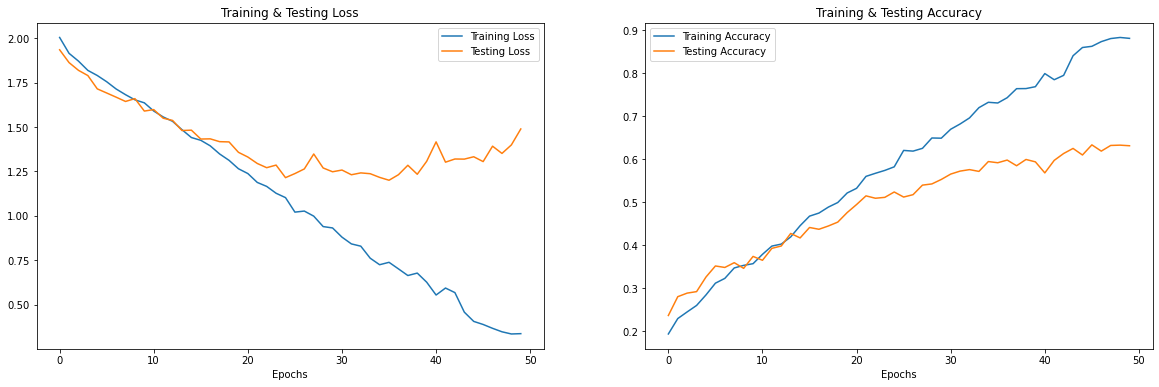

<Figure size 432x288 with 0 Axes>

In [130]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()
plt.savefig('Model Results')

In [131]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [132]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,sad
1,calm,sad
2,happy,sad
3,calm,calm
4,fear,fear
5,fear,fear
6,calm,calm
7,happy,happy
8,calm,calm
9,calm,neutral


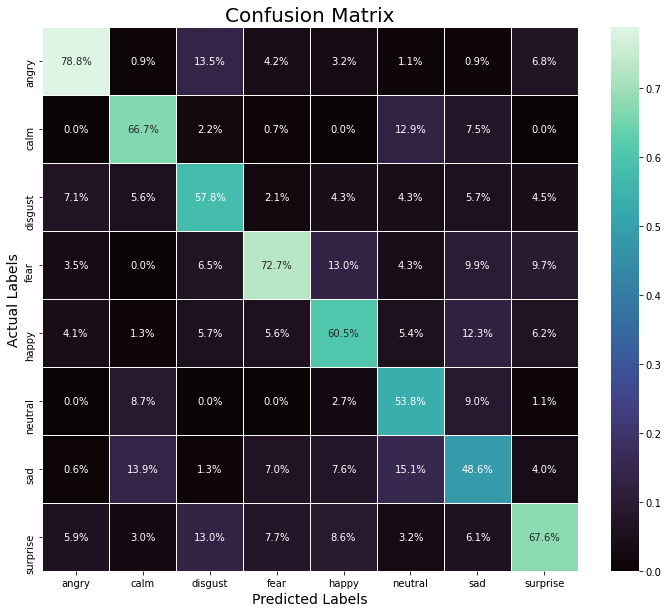

<Figure size 432x288 with 0 Axes>

In [144]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm/ np.sum(cm), linecolor='white', cmap='mako', linewidth=1, annot=True, fmt='.1%')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
plt.savefig('Confussion')

In [134]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.79      0.69      0.74       194
        calm       0.67      0.82      0.74       188
     disgust       0.58      0.69      0.63       193
        fear       0.73      0.54      0.62       191
       happy       0.61      0.61      0.61       185
     neutral       0.54      0.52      0.53        96
         sad       0.49      0.56      0.52       184
    surprise       0.68      0.57      0.62       209

    accuracy                           0.63      1440
   macro avg       0.63      0.62      0.62      1440
weighted avg       0.64      0.63      0.63      1440

